In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
import matplotlib.pyplot as plt
#from matplotlib.patches import Circle as crc
#from scipy.optimize import curve_fit
import os

from photutils.detection import DAOStarFinder
from astropy.stats import mad_std

from photutils.aperture import aperture_photometry, CircularAperture, SkyCircularAperture, SkyCircularAnnulus, ApertureStats
from astropy.coordinates import SkyCoord, FK5
from astropy.stats import sigma_clipped_stats
from astropy.timeseries import TimeSeries
from photutils.detection import find_peaks
from photutils.centroids import centroid_quadratic
from photutils.profiles import RadialProfile
from scipy.optimize import curve_fit

#from astropy.visualization import astropy_mpl_style
#plt.style.use(astropy_mpl_style)
#plt.rcParams['figure.figsize'] = [16,10]

import warnings; warnings.filterwarnings('ignore')

prop_cycle = plt.rcParams['axes.prop_cycle']
def_colors = prop_cycle.by_key()['color']
#print(def_colors) #['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
def_colors_lightened = ['#99cbed','#ffcc9f','#9fe59f','#efa8a8','#d4c2e5','#d6b8b2','#f4c9e7','#cccccc','#eded9e','#9aecf4']
def_colors_darkened = ['#16537e','#bc5800','#1f701f','#961b1c','#683e8e','#623c34','#c92998','#595959','#848418','#108591']

import io
def print_to_string(*args, **kwargs):
    output = io.StringIO()
    print(*args, file=output, **kwargs)
    contents = output.getvalue()
    output.close()
    return contents

In [2]:
#should go with like, the class that manages all these things.
def getFilepath(number,folder='output/',ext='.fits'):
    return folder + "{:03d}".format(number) + ext

#I feel like these converters should go in a helper module
def hmstodays(h,m,s):
    return h/24 + m/(24*60) + s/(24*60*60)

def hmsToDeg(h,m,s):
    return 15*h + 15*m/60 + 15*s/3600

def dmsToDeg(d,m,s):
    return d + m/60 + s/3600

#helper class
def getTimeFromDate(dateStr):
    #dateStr format: YYYY-MM-DD'T'HH:MM:SS.SSS
    split = dateStr.split(':')
    #print(split)
    hourStr = split[0][-2:]; minStr = split[1]; secStr = split[2]
    second = float(secStr); minute = float(minStr); hour = float(hourStr)
    #print(hour,minute,second)
    time = hour + (minute + (second/60))/60
    return time

#this is a useful method, idk where to put it
def genTimesFromTable(table,debug=False):
    times = np.zeros(len(table))
    for d,date in enumerate(table['time']):
        if debug: print(d,date)
        times[d] = getTimeFromDate(date)
    return times

#this isn't super used; should maybe go in a general purpose module though
def diffMag(fluxV,fluxC):
    return -2.5 * np.log10(fluxV/fluxC)

In [42]:
photTable = Table.read('photometry/simple.ecsv')
#print(photTable)

In [44]:
#first, save the old strings as a seperate column so they don't disappear
photTable['datetime'] = photTable['time']
#next we will create a new variable/list with the times aas numbers instead of strings
times = genTimesFromTable(photTable)

In [45]:
photTable.show_in_notebook()

idx,time,sCA,sCB,sCD,sCE,sCF,sCG,sCH,sCI,sA,sB,sC,sD,sCJ,sCK,sCL,sBA,sBB,sBC,sBD,sBE,sCM,sCN,sCO,sCP,target,datetime
0,2023-08-08T09:42:04.740,202894.08615398838,313954.9860488031,207703.9338661193,470320.3124287261,234030.44847315716,325148.7535655866,410105.5273800412,244702.49751597896,280048.8531323841,262083.66669986647,226947.73046857247,244086.002126054,212511.89727843393,461593.742082751,213353.19869058992,231201.14049671675,166918.87759319128,235661.57918900793,196617.51162197068,195295.62594227894,519141.21575713146,280145.3289842269,259314.83602849854,353909.4961201241,262083.8853703795,2023-08-08T09:42:04.740
1,2023-08-08T06:53:35.760,192477.7428323507,297692.0521922072,196052.37082560477,447671.8260992354,222984.19382416917,310547.9788742829,388265.0484670728,230171.23107409116,266220.93215913716,250124.50432812818,214412.2345333984,231303.37059092894,200323.78033072437,438846.6382113449,204081.0358016676,219231.63641776392,157739.08219809466,223266.30718356353,188049.08909547163,185235.3500835007,491552.1656846051,268850.68970127625,244489.42440612792,337985.67584678094,250097.9177385262,2023-08-08T06:53:35.760
2,2023-08-08T09:09:16.440,205309.39479852596,318799.3260374045,209793.93353369329,478580.09137103637,238176.8276269067,328541.99601973116,414633.6845051346,247458.09943457026,283428.5758094187,263732.6388754897,229648.18698539634,246633.3087056984,214762.03037931162,465641.50276089343,218534.28884557582,233470.64730099728,170078.05409253036,238855.82989413646,199329.20164851254,196929.50219426074,528842.4863399633,285981.2415888472,263197.2955089346,360696.90063718817,263737.24664129893,2023-08-08T09:09:16.440
3,2023-08-08T07:45:51.800,220736.24687770515,340235.3169935651,223522.80616598684,510360.43647518504,254765.87773706752,352633.10195759713,439879.01569564495,264651.78282246366,302822.0749587216,285868.2942389456,245523.61053075513,263956.04745079787,228890.73530311146,500554.6437906837,233829.20677206796,248873.2999840308,181672.2926724918,254973.82338255158,213987.75141326824,212569.6814561093,565055.3553955314,305304.99896731874,283987.2246301026,389029.13785859157,285884.37695630104,2023-08-08T07:45:51.800
4,2023-08-08T08:13:22.100,219458.85928259976,339751.69110379845,223731.05727728087,513480.8940816568,255642.3309428823,352525.54422570113,440399.4838171599,262903.4211259215,301980.89989465155,283800.66333310126,245070.77661965444,263526.3722731091,227218.93118837549,496730.7757990272,232577.54328964782,248862.4563612435,180770.23043169786,253899.18763922987,214004.32900216308,211013.41613297246,568109.1409290613,305602.80200567667,279301.92397067556,386180.880551859,283812.60591210757,2023-08-08T08:13:22.100
5,2023-08-08T08:54:40.750,206764.81958664992,317740.43599645066,209609.88543036417,478376.185962303,237493.63255985154,328697.8872567646,412655.8841379241,246616.15238571647,283878.07772384654,264086.42394810065,229736.36815131607,245240.2323600409,212066.87945785606,465815.83323496394,218524.9482922049,234225.45846359394,168796.38163054982,239051.8172148805,199519.5941504361,197567.6641233043,529337.9281117305,286631.76115225296,261783.21581865265,360470.0176203206,264082.91938706965,2023-08-08T08:54:40.750
6,2023-08-08T07:41:00.650,213242.305306953,331538.4239191425,216489.5561174137,495508.6235035539,247309.90760523925,343119.1271746828,428555.4871367482,255611.58544413064,294291.5266843599,276544.01729527826,238139.50798930653,255941.4371507366,222242.98073879827,487122.9730419959,226511.08913845563,241190.2183143984,176216.54527867533,247500.94149741883,207013.4053366118,205619.79177097764,545262.2722089881,295287.27672721044,274496.5917569772,375738.24129487836,276473.9979341129,2023-08-08T07:41:00.650
7,2023-08-08T10:01:06.060,205387.4854532662,318202.3879439977,210390.80657185917,483802.4885702023,239140.7591595485,331332.74393397325,414037.9223252055,247825.4940798782,286950.82766132714,266535.70237442874,230536.2218743111,247649.36299924427,214286.09388578462,468101.77309825,2195

In [46]:
#Now we will replace the old time column with the number version
photTable['time'] = times
## Rerun the cell above to verify it worked

In [47]:
#Now, it's helpful for us when we're looking at the tables if it's in order.
#It doesn't matter when plotting, because it would put the dots in the right places, but for us and tables it good.
photTable.sort('time')
## Rerun the cell two up to verify it worked. 
#now, we also want times to be the new ordered version
times = photTable['time'].data

In [49]:
#We shall also trim out any bad columns. 
#You'll have to use your own discretion, but get rid of any really bad ones. We can justify later ;p

photTable.remove_column('sCO')

## MAKE SURE TO RELOAD YOUR NAMES AFTER REMOVING A COLUMN

In [52]:
names = list(photTable.columns.keys())
print(names)
names = list(photTable.columns.keys())[1:-1]
print(names)

['time', 'sCB', 'sCD', 'sCE', 'sCF', 'sCG', 'sCH', 'sCI', 'sA', 'sB', 'sC', 'sD', 'sCJ', 'sCK', 'sCL', 'sBA', 'sBB', 'sBC', 'sBD', 'sBE', 'sCM', 'sCN', 'sCP', 'target', 'datetime']
['sCB', 'sCD', 'sCE', 'sCF', 'sCG', 'sCH', 'sCI', 'sA', 'sB', 'sC', 'sD', 'sCJ', 'sCK', 'sCL', 'sBA', 'sBB', 'sBC', 'sBD', 'sBE', 'sCM', 'sCN', 'sCP', 'target']


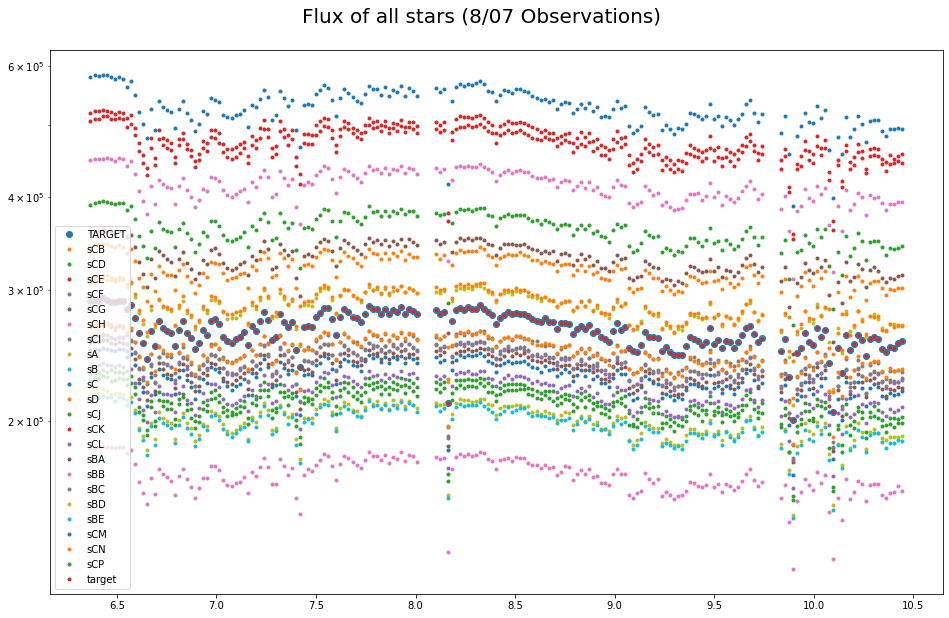

In [54]:
fig,ax = plt.subplots(1,1,figsize=(16,10))


ax.plot(photTable['time'].data,photTable[n].data,'o',label='TARGET')
for n in names:
    ax.plot(photTable['time'].data,photTable[n].data,'.',label=n)
#for n in ['sAU','sA','sK','sAE']:
    #ax.plot(times,photTable[n].data,'.',label=n)
#ax.plot(times,photTable['sAU'].data,'o',label='sAU')
ax.legend()
ax.set_yscale('log')

fig.suptitle('Flux of all stars (8/07 Observations)',fontsize=20,y=0.94)
plt.show()

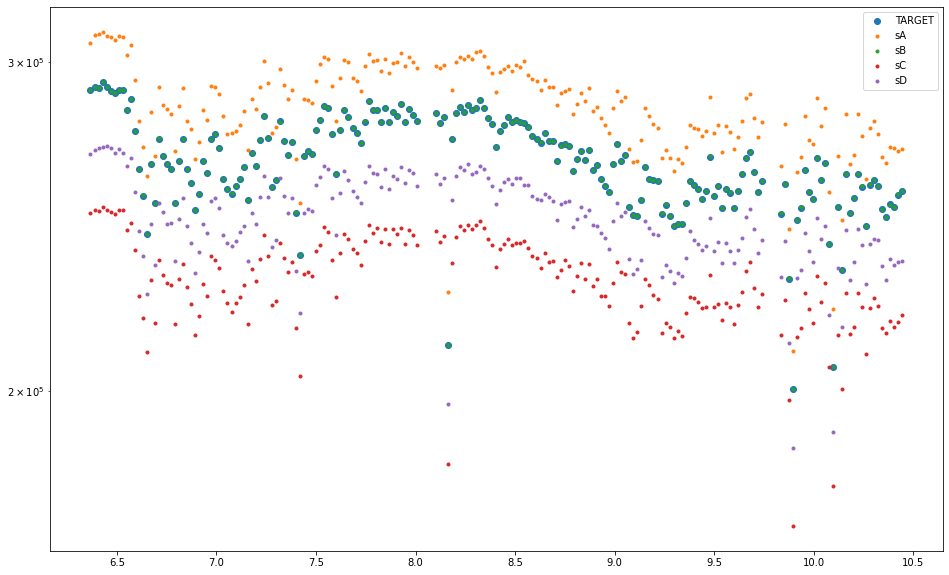

In [9]:
fig,ax = plt.subplots(1,1,figsize=(16,10))

#for n in names:
    #ax.plot(times,photTable[n].data,'.',label=n)
ax.plot(photTable['time'].data,photTable[n].data,'o',label='TARGET')
for n in ['sA','sB','sC','sD']:
    ax.plot(photTable['time'].data,photTable[n].data,'.',label=n)
#ax.plot(times,photTable['sAU'].data,'o',label='sAU')
ax.legend()
ax.set_yscale('log')

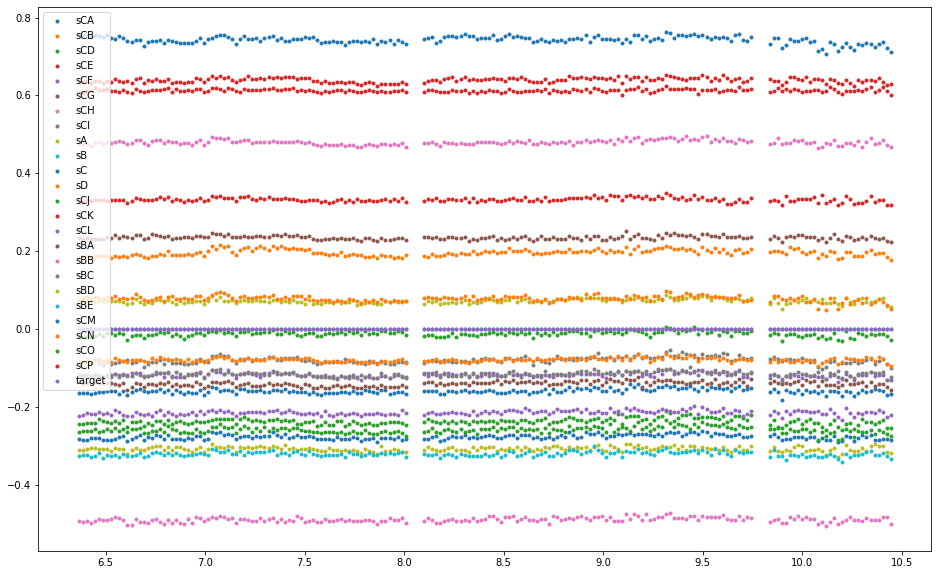

In [10]:
fig,ax = plt.subplots(1,1,figsize=(16,10))

for n in names:
    ax.plot(photTable['time'].data,diffMag(photTable['target'].data,photTable[n].data),'.',label=n)
#ax.plot(times,photTable[n].data,'o',label='TARGET')
#ax.plot(times,photTable['sAU'].data,'o',label='sAU')
ax.legend()
plt.show()

In [11]:
diffTable = Table([photTable['time'].data],names=['time'])
#diffTable['time'] = times
#print(diffTable)

for n in names[:-1]:
    #print(n)
    diffTable[n] = diffMag(photTable[n].data,photTable['target'].data)
#diffMag(target_val,photTable[n].data)

#diffTable.show_in_browser()

In [12]:
relTable = Table([photTable['time'].data],names=['time'])
#diffTable['time'] = times
#print(diffTable)

for n in names[:-1]:
    #print(n)
    relTable[n] = photTable['target'].data / photTable[n].data
#diffMag(target_val,photTable[n].data)

#diffTable.show_in_browser()

In [ ]:
#print(diffTable.argsort('time'))
#print(diffTable.sort('time'))
#diffTable.show_in_notebook()

#diffNames = names[:-1]

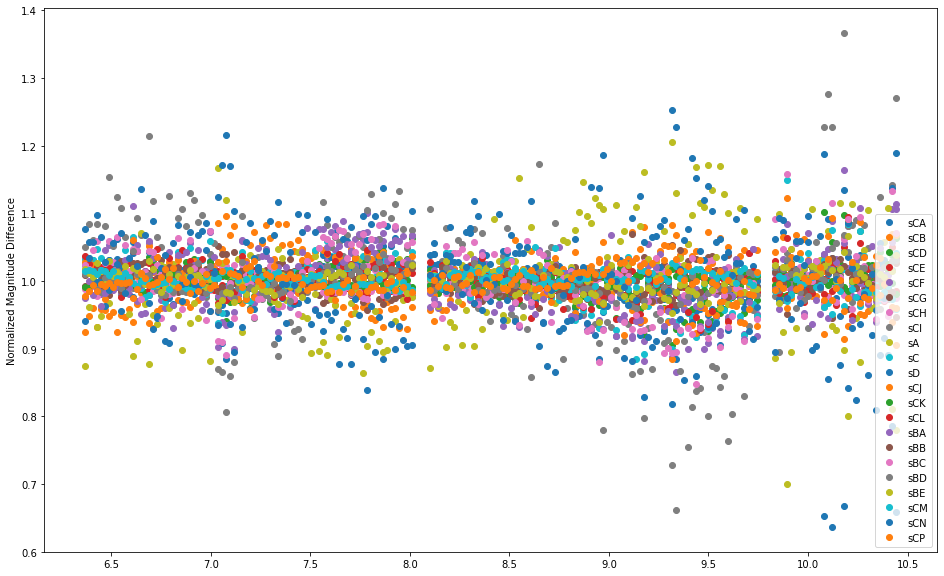

In [13]:
fig,ax = plt.subplots(1,1,figsize=(16,10))

for n in names[:-1]:
    if n == 'sCO': continue
    if n == 'sB': continue #This was was crazy bc mean difference is so small -> blows up
    ax.plot(photTable['time'].data,diffTable[n]/np.mean(diffTable[n]),'o',label=n)

#ax.plot(times,photTable[n].data,'o',label='TARGET')
#ax.plot(times,photTable['sAU'].data,'o',label='sAU')
#ax.legend()
ax.legend()
#ax2.legend(loc=(1.01,0.92))
#ax.set_ylabel("Relative Flux")
ax.set_ylabel("Normalized Magnitude Difference")
plt.show()

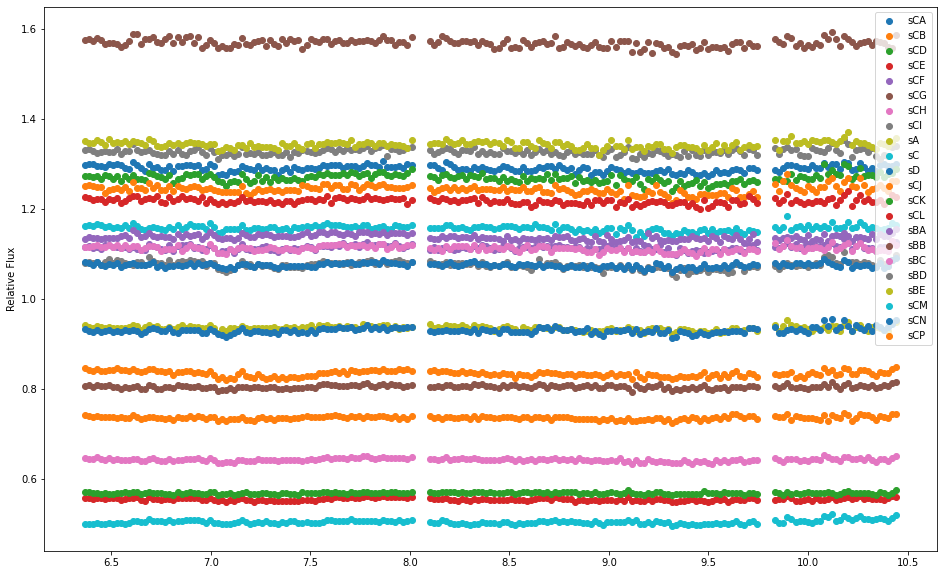

In [14]:
fig,ax = plt.subplots(1,1,figsize=(16,10))

for n in names[:-1]:
    if n == 'sCO': continue
    if n == 'sB': continue
    ax.plot(photTable['time'].data,relTable[n],'o',label=n)

#ax.plot(times,photTable[n].data,'o',label='TARGET')
#ax.plot(times,photTable['sAU'].data,'o',label='sAU')
#ax.legend()
ax.legend()
#ax2.legend(loc=(1.01,0.92))
ax.set_ylabel("Relative Flux")
#ax2.set_ylabel("Magnitude Difference")
plt.show()

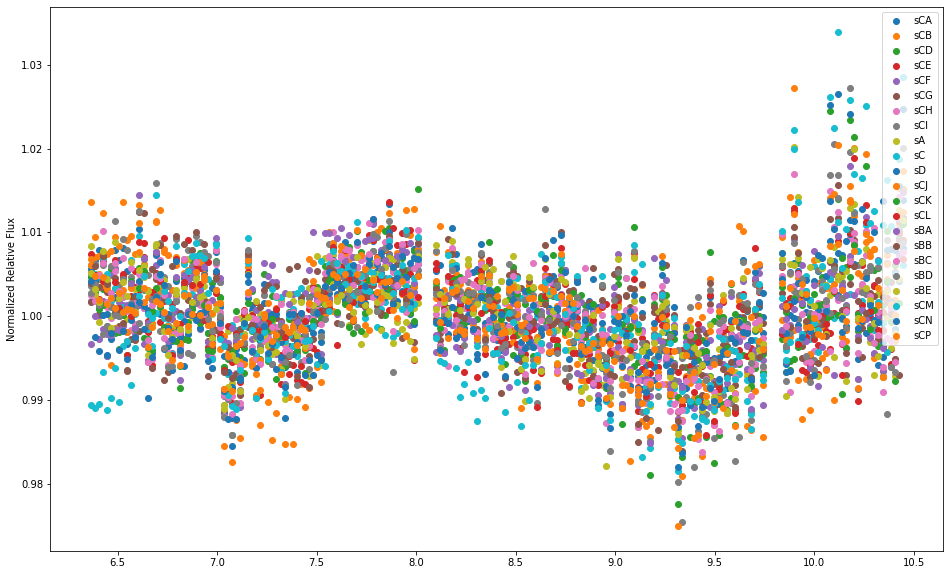

In [15]:
fig,ax = plt.subplots(1,1,figsize=(16,10))

for n in names[:-1]:
    if n == 'sCO': continue
    if n == 'sB': continue
    ax.plot(photTable['time'].data,relTable[n]/np.mean(relTable[n]),'o',label=n)

#ax.plot(times,photTable[n].data,'o',label='TARGET')
#ax.plot(times,photTable['sAU'].data,'o',label='sAU')
#ax.legend()
ax.legend()
#ax2.legend(loc=(1.01,0.92))
ax.set_ylabel("Normalized Relative Flux")
#ax2.set_ylabel("Magnitude Difference")
plt.show()

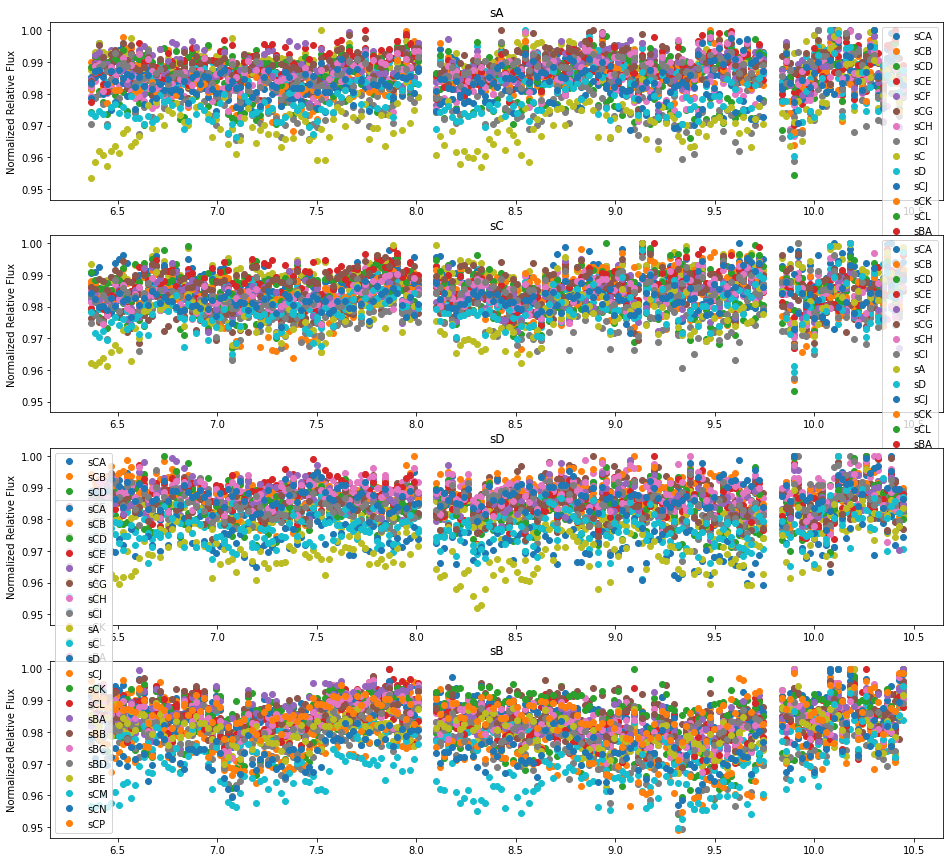

In [16]:
fig,axs = plt.subplots(4,1,figsize=(16,15),sharey=True)

for n in names[:-1]:
    if n == 'sCO': continue
    #if n == 'sB': continue
    for i,t in enumerate(['sA','sC','sD','sB']):
        if n == t: continue
        if n == 'sB': continue
        axs[i].plot(photTable['time'].data,(photTable[t].data/photTable[n].data)/np.max((photTable[t].data/photTable[n].data)),'o',label=n)
        axs[i].set_title(t)
#ax.plot(times,photTable[n].data,'o',label='TARGET')
#ax.plot(times,photTable['sAU'].data,'o',label='sAU')
#ax.legend()

for i in range(4):
    
    axs[i].legend(loc=i)
    axs[i].set_ylabel("Normalized Relative Flux")
#ax2.set_ylabel("Magnitude Difference")
plt.show()

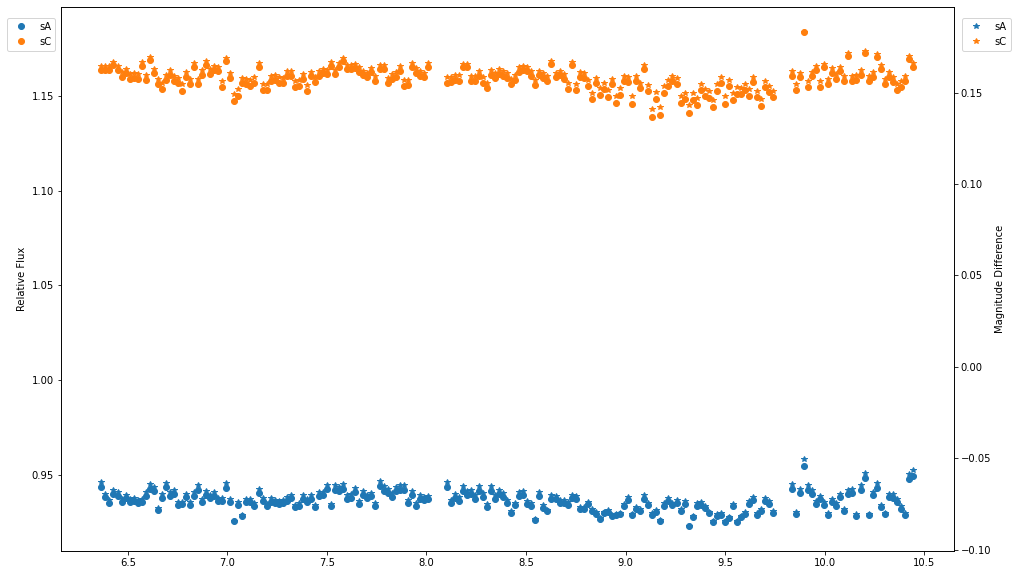

In [17]:
fig,ax = plt.subplots(1,1,figsize=(16,10))

for n in ['sA','sC']:
    ax.plot(times,relTable[n],'o',label=n)
    
ax2 = ax.twinx()
for n in ['sA','sC']:
    ax2.plot(times,diffTable[n],'*',label=n)

#ax.plot(times,photTable[n].data,'o',label='TARGET')
#ax.plot(times,photTable['sAU'].data,'o',label='sAU')
#ax.legend()
ax.legend(loc=(-0.06,0.92))
ax2.legend(loc=(1.01,0.92))
ax.set_ylabel("Relative Flux")
ax2.set_ylabel("Magnitude Difference")
plt.show()

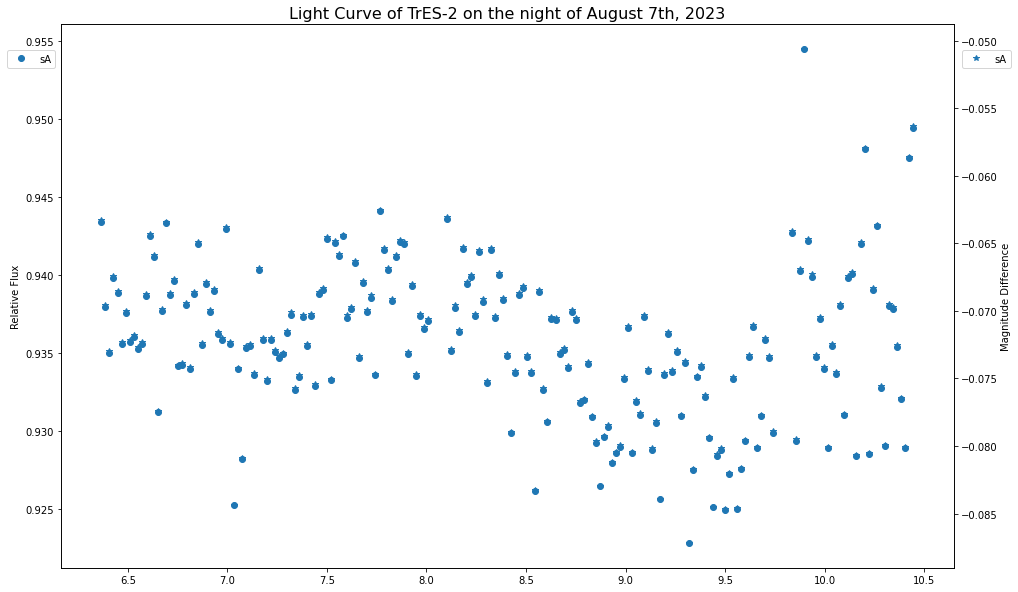

In [20]:
fig,ax = plt.subplots(1,1,figsize=(16,10))

for n in ['sA']:#,'sC']:
    ax.plot(times,relTable[n],'o',label=n)
    
ax2 = ax.twinx()
for n in ['sA']:#,'sC']:
    ax2.plot(times,diffTable[n],'*',label=n)

#ax.plot(times,photTable[n].data,'o',label='TARGET')
#ax.plot(times,photTable['sAU'].data,'o',label='sAU')
#ax.legend()
ax.legend(loc=(-0.06,0.92))
ax2.legend(loc=(1.01,0.92))
ax.set_ylabel("Relative Flux")
ax2.set_ylabel("Magnitude Difference")
ax.set_title("Light Curve of TrES-2 on the night of August 7th, 2023",fontsize=16)
plt.show()

Okay, I want to do some binning with the relative flux for this guy. I want to take a look at how each of the relative fluxes from all the stars is when binned. 

As a precursor, I think I have to normalize the relative fluxes. Before I was dividing by the mean, but maybe dividing by the maximum value is better?

In [22]:
normRelTable = relTable.copy()

for n in names[:-1]:
    normRelTable[n] = relTable[n].data / np.max(relTable[n].data)
    
#normRelTable.show_in_notebook()

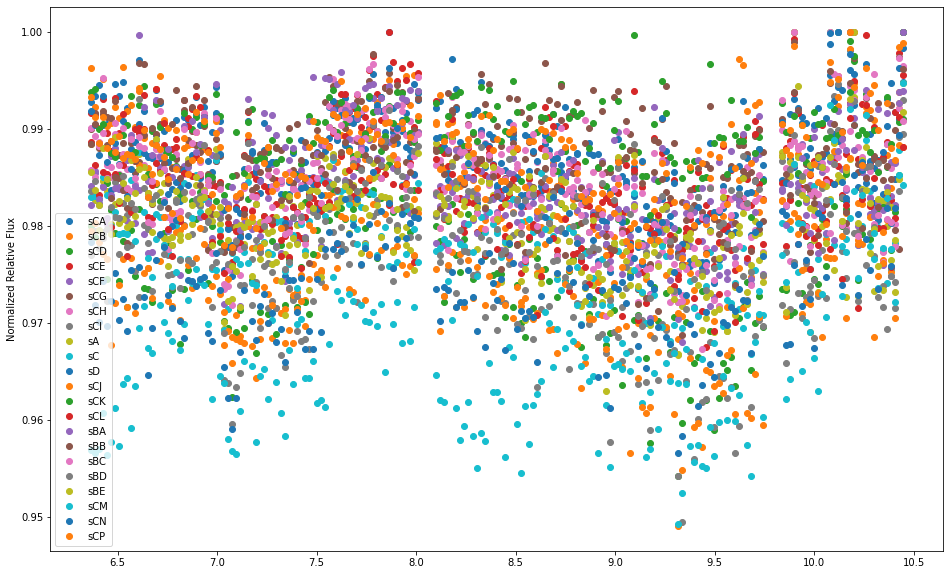

In [25]:
fig,ax = plt.subplots(1,1,figsize=(16,10))

for n in names[:-1]:
    if n == 'sCO': continue
    if n == 'sB': continue
    ax.plot(normRelTable['time'].data,normRelTable[n],'o',label=n)

#ax.plot(times,photTable[n].data,'o',label='TARGET')
#ax.plot(times,photTable['sAU'].data,'o',label='sAU')
#ax.legend()
ax.legend()
#ax2.legend(loc=(1.01,0.92))
ax.set_ylabel("Normalized Relative Flux")
#ax2.set_ylabel("Magnitude Difference")
plt.show()

In [36]:
#okay, and now I want to bin it. To be a little bit more precise though, 
#I want to calculate a mean, median, std for each TIME, using all the stars
binTab = Table(names=['time','mean','std','median','max','min','values'],dtype=[float,float,float,float,float,float,list])


for time in normRelTable:
    t = 0
    relf = []
    for v in time.values():
        if v >= 2: t = v; continue
        relf.append(v)
        
    mean = np.mean(relf)
    median = np.median(relf)
    std = np.std(relf)
    maxv = np.max(relf)
    minv = np.min(relf)
    
    newrow = {'time':t,'mean':mean,'std':std,'median':median,'max':maxv,'min':minv,'values':relf}
    binTab.add_row(newrow)
    #print(t,relf)
print(binTab)

       time        ...
------------------ ...
           6.36695 ...
 6.387394444444444 ...
6.4078333333333335 ...
           6.42795 ...
           6.44835 ...
 6.468705555555555 ...
 6.489086111111111 ...
 6.509230555555556 ...
 6.529391666666667 ...
            6.5496 ...
               ... ...
10.241527777777778 ...
10.261880555555555 ...
10.281991666666666 ...
10.302319444444445 ...
10.322427777777778 ...
10.342830555555555 ...
           10.3632 ...
10.383277777777778 ...
10.403355555555555 ...
         10.423725 ...
10.444088888888889 ...
Length = 195 rows


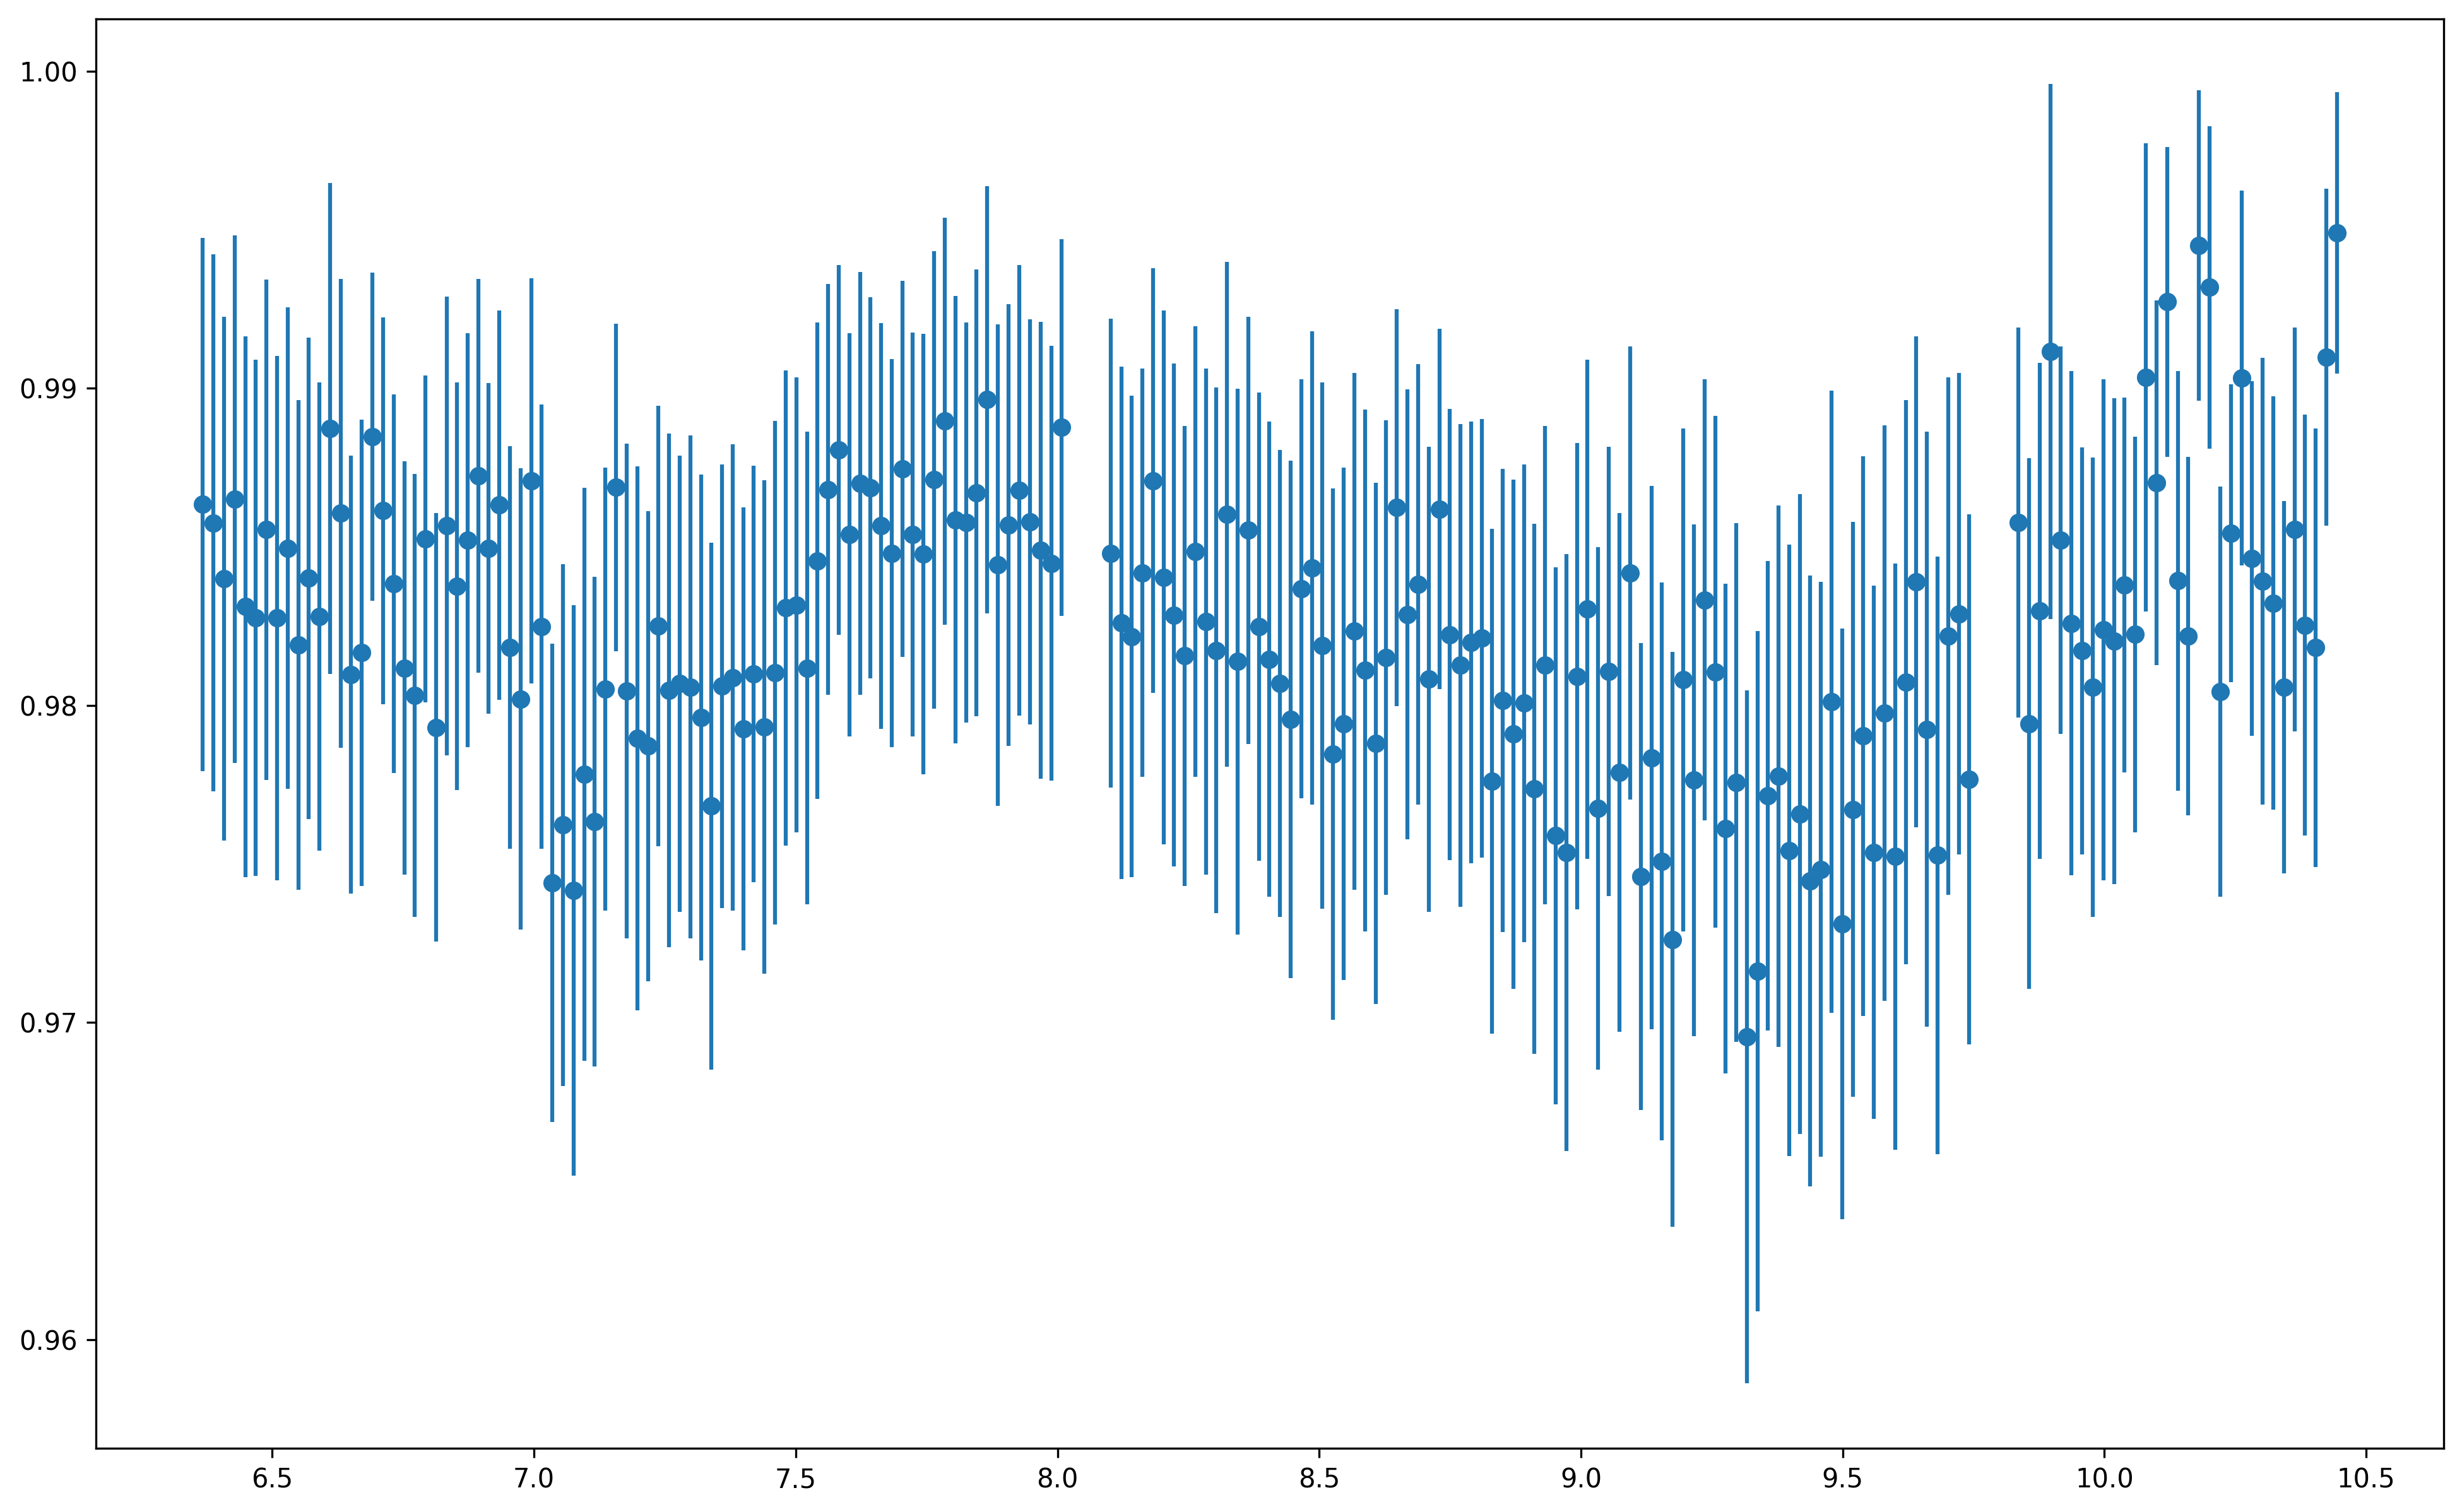

In [41]:
fig,ax = plt.subplots(1,1,figsize=(16,10),dpi=300)

ax.errorbar(binTab['time'],binTab['mean'],binTab['std'],ls='',marker='o')

plt.show()